In [2]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from pathlib import Path
import os

import sklearn
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


In [3]:
path_to_dir = r"./archive"
class_names = ["FAKE", "REAL"]

In [4]:
# Declare preprocessing functions
tf.random.set_seed(999)
img_size = 128
def get_label(file_path: str):
    parsed = tf.strings.split(file_path, os.path.sep)
    parent = parsed[-2]
    return tf.argmax(parent == class_names)


def decode_img(img):
    img = tf.io.decode_image(img, channels=3, expand_animations=False)

    # shape = [H, W, 3]
    shape = tf.shape(img)
    h = shape[0]
    w = shape[1]
    min_dim = tf.minimum(h, w)

    img = tf.image.random_crop(img, size=[min_dim, min_dim, 3])
    img = tf.image.resize(img, [img_size, img_size])

    img = tf.cast(img, tf.float32) / 255.0
    return img



def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label



In [5]:


train_filepaths = [str(file.absolute()) for file in Path(path_to_dir).glob("train/*/*.jp*g")]
print(train_filepaths)
test_filepaths = [str(file.absolute()) for file in Path(path_to_dir).glob("test/*/*.jp*g")]

train_ds = tf.data.Dataset.from_tensor_slices(train_filepaths)
test_ds = tf.data.Dataset.from_tensor_slices(test_filepaths)
train_count = len(train_ds)
test_count = len(test_ds)
print(f"train image count: {train_count}\ntest image count: {test_count}")
train_ds = train_ds.shuffle(train_count, reshuffle_each_iteration=False)
test_ds = test_ds.shuffle(test_count, reshuffle_each_iteration=False)


print("train file examples")
for f in train_ds.take(5):
    print(f.numpy())
print("test file examples")
for f in test_ds.take(5):
    print(f.numpy())







['/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/1006 (3).jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/1808 (8).jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/3261 (2).jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/0892 (2).jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/0250 (5).jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/0071.jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/4620 (3).jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/1596 (9).jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/2037 (4).jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/1191 (8).jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/4217.jpg', '/Users/declankorda/COMPSCI4451A/final_project/archive/train/REAL/4227 (2).jpg', '/Users/declankorda/COMPSCI4451A/fi

2025-12-08 15:58:38.936941: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-12-08 15:58:38.936976: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-08 15:58:38.936983: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-08 15:58:38.937127: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-08 15:58:38.937141: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-12-08 15:58:39.126116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-12-08 15:58:39.136381: W ten

In [6]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

Image shape:  (128, 128, 3)
Label:  1
Label Shape:  ()
Type:  REAL


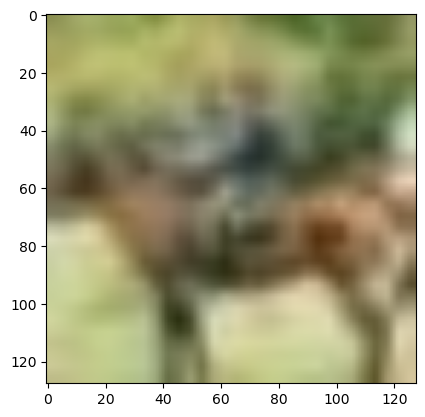

Image shape:  (128, 128, 3)
Label:  1
Label Shape:  ()
Type:  REAL


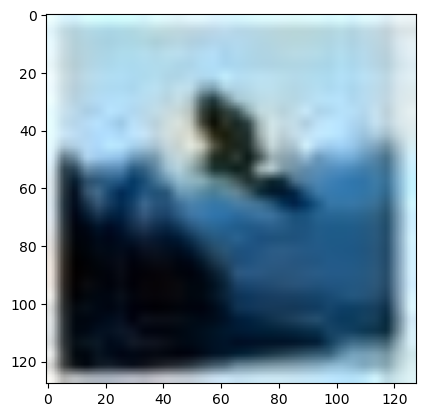

Image shape:  (128, 128, 3)
Label:  1
Label Shape:  ()
Type:  REAL


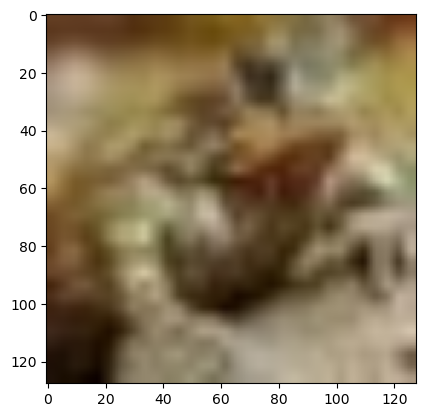

Image shape:  (128, 128, 3)
Label:  1
Label Shape:  ()
Type:  REAL


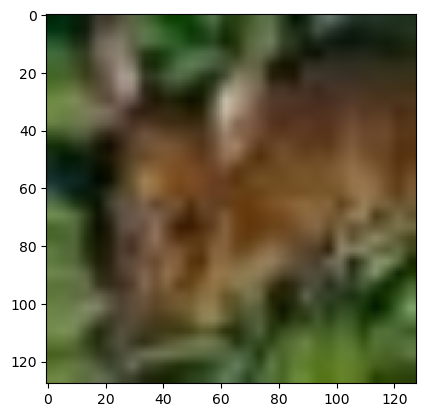

Image shape:  (128, 128, 3)
Label:  1
Label Shape:  ()
Type:  REAL


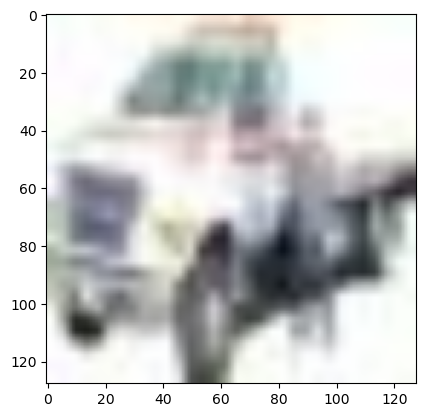

2025-12-08 15:58:39.790126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("Label Shape: ", label.numpy().shape)
    print("Type: ", class_names[label.numpy()])
    plt.imshow(image.numpy())
    plt.show()

In [8]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint


In [9]:


base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable=False
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,434 (9.87 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
# Batching
batch_size = 128
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

print('Training set size: ', len(train_ds)*batch_size)
print('Validation set size: ', len(test_ds)*batch_size)

# Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('imgnet_deepfake.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Define number of epochs and steps per epoch
epochs = 5
steps_per_epoch = len(train_ds)
validation_steps = len(test_ds) 

print(steps_per_epoch)


# Train the model using model.fit
history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=test_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])


Training set size:  100096
Validation set size:  20096
782
Epoch 1/5


2025-12-08 15:58:41.371802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


782/782 ━━━━━━━━━━━━━━━━━━━━ 178s 225ms/step - accuracy: 0.8235 - loss: 0.5349 - val_accuracy: 0.8719 - val_loss: 0.3035
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 173s 221ms/step - accuracy: 0.8598 - loss: 0.3242 - val_accuracy: 0.8735 - val_loss: 0.2992
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 177s 226ms/step - accuracy: 0.8612 - loss: 0.3228 - val_accuracy: 0.8738 - val_loss: 0.2953
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 155s 198ms/step - accuracy: 0.8622 - loss: 0.3230 - val_accuracy: 0.8768 - val_loss: 0.2941
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 159s 203ms/step - accuracy: 0.8623 - loss: 0.3264 - val_accuracy: 0.8769 - val_loss: 0.2949


In [11]:


test_loss, test_acc = model.evaluate(test_ds, verbose=2)



157/157 - 26s - 169ms/step - accuracy: 0.8768 - loss: 0.2941


In [12]:
print(history.history)

{'accuracy': [0.8235099911689758, 0.8597999811172485, 0.8611599802970886, 0.8621799945831299, 0.8622900247573853], 'loss': [0.5349161624908447, 0.32422444224357605, 0.32278212904930115, 0.32301434874534607, 0.32635578513145447], 'val_accuracy': [0.8718500137329102, 0.8734999895095825, 0.8738499879837036, 0.876800000667572, 0.8769000172615051], 'val_loss': [0.30350983142852783, 0.29919952154159546, 0.2953132688999176, 0.29406240582466125, 0.29489666223526]}


157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step
[[0.9039985  0.09600147]
 [0.96038723 0.0396128 ]
 [0.993533   0.00646701]
 ...
 [0.9627966  0.03720342]
 [0.03479058 0.9652094 ]
 [0.18776265 0.8122374 ]]


2025-12-08 16:30:36.439287: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


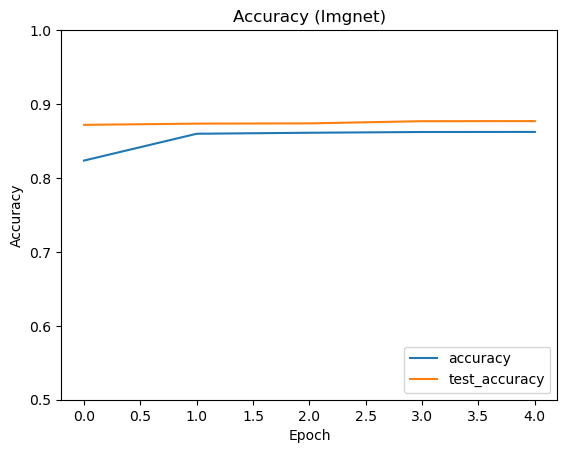

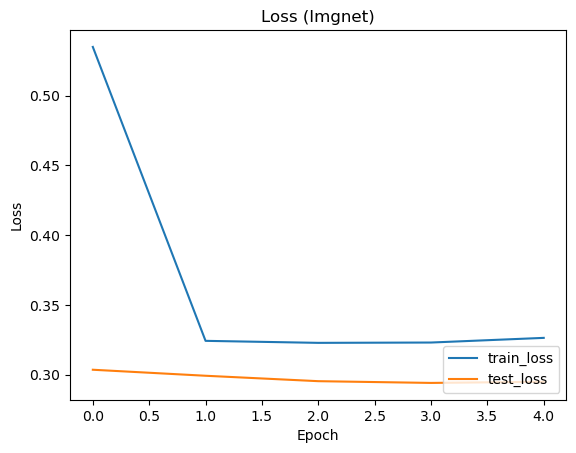

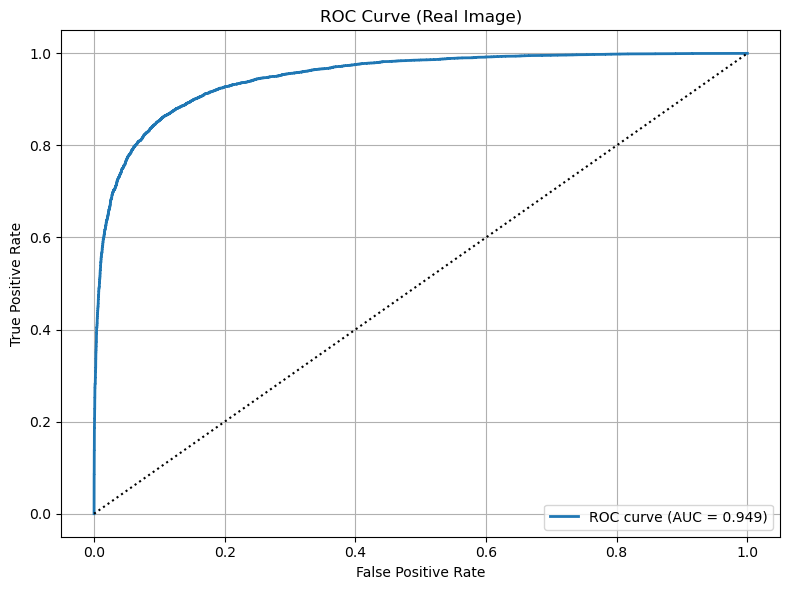

              precision    recall  f1-score   support

        FAKE     0.8571    0.9044    0.8801     10000
        REAL     0.8988    0.8492    0.8733     10000

    accuracy                         0.8768     20000
   macro avg     0.8780    0.8768    0.8767     20000
weighted avg     0.8780    0.8768    0.8767     20000



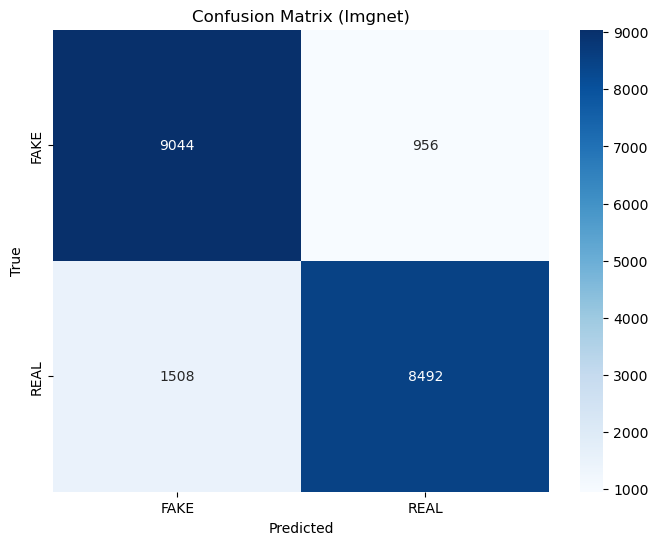

In [20]:
from sklearn.preprocessing import label_binarize
def test_metrics():
    y_pred_probabilities = model.predict(test_ds)
    print(y_pred_probabilities)
    y_true = [label.numpy() for _, label in test_ds]
    y_true = np.concatenate(y_true, axis=0)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='test_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.title("Accuracy (Imgnet)")
    plt.legend(loc='lower right')

    plt.show()

    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss (Imgnet)")
    plt.legend(loc='lower right')

    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred_probabilities[:, -1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle=":", color="black")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Real Image)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
    confusion = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes, target_names=class_names, digits=4)
    print(report)

    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Imgnet)')
    plt.show()
test_metrics()

In [ ]:


model.save("imagenet_deepfake.keras")

